# Direct frequency domain tests

In [1]:
from tclab import runexperiment
import numpy

In [2]:
Qbar = 50
A = 10
omega = 0.01

In [3]:
def send_sine_wave(t, lab):
    lab.Q1(Qbar + A*numpy.sin(omega*t))

In [4]:
%matplotlib inline

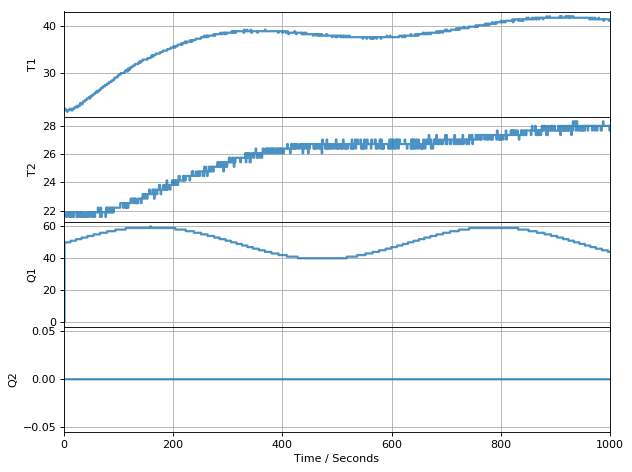

TCLab disconnected successfully.


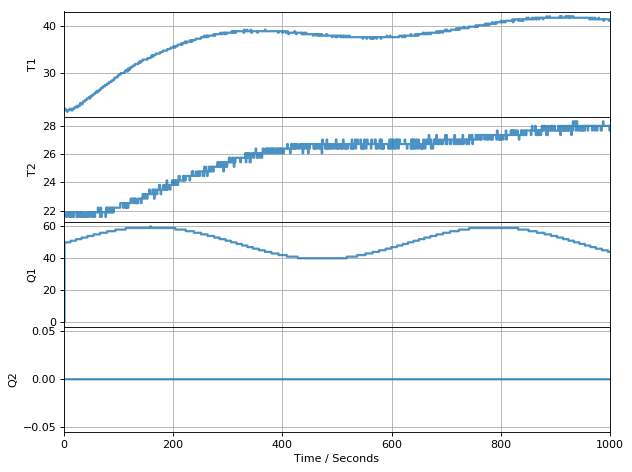

In [5]:
experiment = runexperiment(send_sine_wave, connected=True, plot=True, twindow=1000, time=1000, speedup=1)

In [6]:
import pandas

In [7]:
df = pandas.DataFrame.from_records(experiment.historian.log, columns=experiment.historian.columns, index='Time')

In [8]:
%matplotlib inline

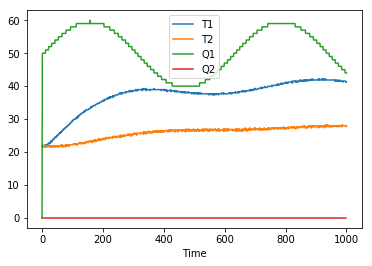

In [9]:
df.plot()